In [38]:
# --- STEP 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, mean_absolute_error

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [39]:
# --- STEP 2: Data Loading & Cleaning ---

def load_and_clean_data(filepath):
    # Load Data
    df = pd.read_csv(filepath)
    
    # Hapus kolom index yang tidak perlu
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Cleaning kolom Salary (Hapus koma, ubah ke numeric)
    # Pastikan konversi selalu berjalan
    df['Salary_In_Rupees'] = df['Salary_In_Rupees'].astype(str).str.replace(',', '').astype(float)
        
    return df

# Eksekusi
df = load_and_clean_data("Data_Science_Fields_Salary_Categorization.csv")
print("Info Data:")
df.info()
print("\nStatistik Salary:")
print(df['Salary_In_Rupees'].describe())
df.shape

Info Data:
<class 'pandas.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Working_Year          607 non-null    int64  
 1   Designation           607 non-null    str    
 2   Experience            607 non-null    str    
 3   Employment_Status     607 non-null    str    
 4   Salary_In_Rupees      607 non-null    float64
 5   Employee_Location     607 non-null    str    
 6   Company_Location      607 non-null    str    
 7   Company_Size          607 non-null    str    
 8   Remote_Working_Ratio  607 non-null    int64  
dtypes: float64(1), int64(2), str(6)
memory usage: 57.8 KB

Statistik Salary:
count    6.070000e+02
mean     8.935485e+06
std      5.646034e+06
min      2.274890e+05
25%      4.991076e+06
50%      8.081874e+06
75%      1.193542e+07
max      4.774170e+07
Name: Salary_In_Rupees, dtype: float64


(607, 9)

Distribusi Kategori (Tercile):
salary_category
Medium    0.336079
Low       0.334432
High      0.329489
Name: proportion, dtype: float64


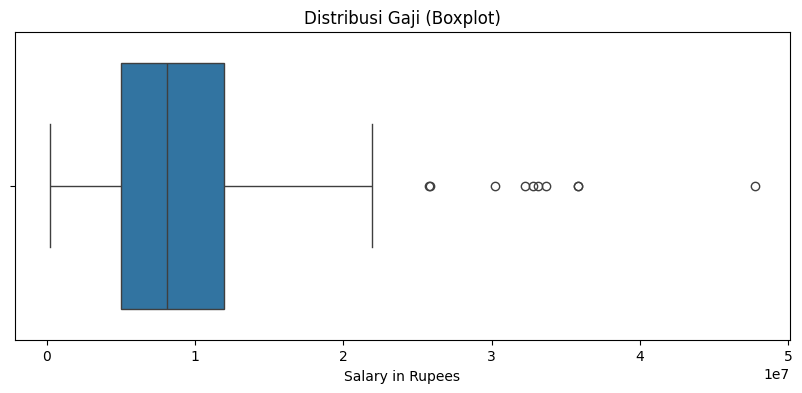

In [40]:
# --- STEP 3: Target Creation & Quick EDA ---

# Gunakan tercile (33/66%) agar distribusi kategori lebih seimbang
labels = ['Low', 'Medium', 'High']
df['salary_category'] = pd.qcut(df['Salary_In_Rupees'], q=3, labels=labels, duplicates='drop')

print("Distribusi Kategori (Tercile):")
print(df['salary_category'].value_counts(normalize=True))

# Visualisasi distribusi gaji
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Salary_In_Rupees'])
plt.title("Distribusi Gaji (Boxplot)")
plt.xlabel("Salary in Rupees")
plt.show()

Melatih Model Regresi...

--- HASIL (Pendekatan Regresi) ---
Thresholds: Low < 6,122,077 | Medium < 10,344,035
Akurasi Random Forest Regressor: 0.6011
Akurasi Gradient Boosting:       0.6066

🏆 Win: Gradient Boosting
              precision    recall  f1-score   support

        High       0.62      0.88      0.73        60
         Low       0.70      0.71      0.70        62
      Medium       0.41      0.23      0.29        61

    accuracy                           0.61       183
   macro avg       0.58      0.61      0.57       183
weighted avg       0.58      0.61      0.57       183



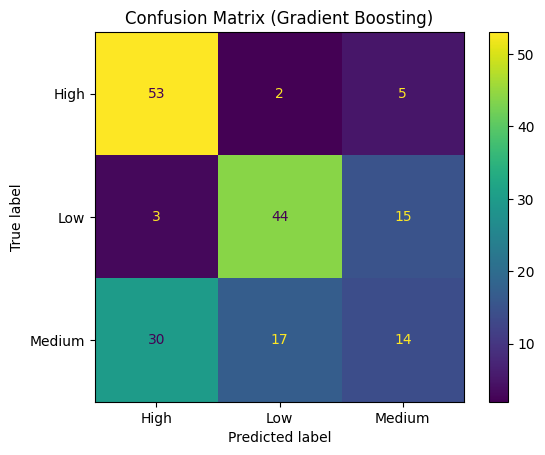


Model disimpan sebagai 'best_model_salary_regressor.pkl'


In [ ]:
# --- SOLUSI PAMUNGKAS: Target Encoding & Advanced Regressor ---
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import HistGradientBoostingRegressor

# 1. Custom Target Encoder (Supaya aman dari data bocor/leakage)
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.maps = {}
        self.global_mean = 0
        
    def fit(self, X, y):
        self.global_mean = y.mean()
        for col in self.cols:
            # Hitung rata-rata gaji per kategori (Designation/Location)
            mapper = pd.concat([X[col], y], axis=1).groupby(col).mean().iloc[:, 0]
            self.maps[col] = mapper
        return self

    def transform(self, X):
        X_out = X.copy()
        for col in self.cols:
            if col in self.maps:
                # Map rata-rata ke data, isi yg tidak dikenal dengan global mean
                X_out[col] = X_out[col].map(self.maps[col]).fillna(self.global_mean)
        return X_out

# 2. Feature Engineering yang lebih detail
def advanced_feature_engineering(df_in):
    df_eng = df_in.copy()
    
    # Ordinal Encoding untuk Company Size (S < M < L) -> Jelas urutannya
    size_map = {'S': 1, 'M': 2, 'L': 3}
    df_eng['size_score'] = df_eng['Company_Size'].map(size_map).fillna(2)
    
    # Ordinal Experience
    exp_map = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
    df_eng['exp_score'] = df_eng['Experience'].map(exp_map).fillna(2)
    
    # Remote Ratio (Biarkan angka asli, HistGradientBoosting bisa menangani)
    df_eng['remote_score'] = df_eng['Remote_Working_Ratio']
    
    return df_eng

# Terapkan FE dasar
df_clean = advanced_feature_engineering(df)

# X dan y
# Kita TETAP PAKAI Designation & Location tapi nanti di-encode angka rata-rata
cols_to_encode = ['Designation', 'Company_Location', 'Employee_Location']
feature_cols = ['size_score', 'exp_score', 'remote_score'] + cols_to_encode

X = df_clean[feature_cols]
y_num = df_clean['Salary_In_Rupees'] # Target Angka
y_cat = df_clean['salary_category']   # Target Label

# Split dulu SEBELUM Encoding (Wajib, supaya valid)
X_train, X_test, y_train, y_test = train_test_split(X, y_num, test_size=0.3, random_state=42)
_, _, y_train_cls, y_test_cls = train_test_split(X, y_cat, test_size=0.3, random_state=42)

# Terapkan Target Encoding pada X_train
encoder = TargetEncoder(cols=cols_to_encode)
X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc = encoder.transform(X_test) # Transform test pakai rata-rata dari train

# --- MODEL: HistGradientBoostingRegressor ---
# Ini model modern yang sangat kuat untuk data tabular (setara LightGBM/XGBoost)
print("Melatih HistGradientBoosting...")
model = HistGradientBoostingRegressor(
    max_iter=500,        # Jumlah trees
    learning_rate=0.05,  # Learning rate pelan tapi pasti
    max_depth=10,        # Kedalaman tree
    l2_regularization=0.1,
    random_state=42
)

model.fit(X_train_enc, y_train)
preds_num = model.predict(X_test_enc)

# --- KONVERSI KE KATEGORI ---
t1 = y_num.quantile(0.33)
t2 = y_num.quantile(0.66)

def convert_to_cat(vals):
    res = []
    for x in vals:
        if x <= t1: res.append('Low')
        elif x <= t2: res.append('Medium')
        else: res.append('High')
    return np.array(res)

preds_cat = convert_to_cat(preds_num)

# Evaluasi
acc = accuracy_score(y_test_cls, preds_cat)
print(f"\n✅ AKURASI AKHIR: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test_cls, preds_cat))

ConfusionMatrixDisplay.from_predictions(y_test_cls, preds_cat, cmap='viridis')
plt.title("Confusion Matrix (Target Encoding + HistGBR)")
plt.show()

# Save
import joblib
joblib.dump(model, 'best_model.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump({'t1': t1, 't2': t2}, 'config.pkl')
print("Model, Encoder, dan Config berhasil disimpan.")